In [5]:
import os
import sys
os.chdir('/app')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
plt.style.use('seaborn-v0_8-whitegrid')

In [6]:
# Load data 
df = pd.read_csv('data/clean_listings.csv')

print("PREPARING FEATURES FOR MODELING")
print("--" * 60)

features = [
    'bedrooms', 'bathrooms', 'size_sqft',
    'amenity_score', 'has_parking', 'has_pool',
    'has_gym', 'has_security', 'has_garden',
    'is_land', 'location', 'property_type'
]
target = 'price_kes'

df_model = df[features + [target]].dropna().copy()
print(f"Records for modeling: {len(df_model)}")

le_location = LabelEncoder()
le_type = LabelEncoder()
df_model['location_enc'] = le_location.fit_transform(df_model['location'].astype(str))
df_model['property_type_enc'] = le_type.fit_transform(df_model['property_type'].astype(str))

feature_cols = [
    'bedrooms', 'bathrooms', 'size_sqft',
    'amenity_score', 'has_parking', 'has_pool',
    'has_gym', 'has_security', 'has_garden',
    'is_land', 'location_enc', 'property_type_enc'
]

X = df_model[feature_cols]
y = df_model[target]

print(f"\nFeatures: {feature_cols}")
print(f"Target: {target}")
print(f"\nX shape: {X.shape}")
print(f"y range: KES {y.min():,.0f} to KES {y.max():,.0f}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set:  {X_train.shape[0]} records")
print(f"Test set:      {X_test.shape[0]} records")
print(f"\nTrain price range: KES {y_train.min():,.0f} - KES {y_train.max():,.0f}")
print(f"Test price range:  KES {y_test.min():,.0f} - KES {y_test.max():,.0f}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

PREPARING FEATURES FOR MODELING
------------------------------------------------------------------------------------------------------------------------
Records for modeling: 469

Features: ['bedrooms', 'bathrooms', 'size_sqft', 'amenity_score', 'has_parking', 'has_pool', 'has_gym', 'has_security', 'has_garden', 'is_land', 'location_enc', 'property_type_enc']
Target: price_kes

X shape: (469, 12)
y range: KES 37,000 to KES 1,200,000

Training set:  375 records
Test set:      94 records

Train price range: KES 37,000 - KES 1,200,000
Test price range:  KES 40,000 - KES 967,500


In [7]:
# Train models
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = np.clip(lr.predict(X_test_scaled), 0, None)

rf = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = np.clip(rf.predict(X_test), 0, None)

models = {'Linear Regression': (lr, y_pred_lr, True), 'Random Forest': (rf, y_pred_rf, False)}

if HAS_XGBOOST:
    xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = np.clip(xgb_model.predict(X_test), 0, None)
    models['XGBoost'] = (xgb_model, y_pred_xgb, False)

In [8]:
# Model comparison
def eval_model(name, y_pred):
    return {
        'Model': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

results = [eval_model(name, pred) for name, (_, pred, _) in models.items()]
comparison_df = pd.DataFrame(results)
comparison_df['MAE_KES'] = comparison_df['MAE'].apply(lambda x: f'{x:,.0f}')
comparison_df['RMSE_KES'] = comparison_df['RMSE'].apply(lambda x: f'{x:,.0f}')

print("\n" + "-" * 60)
print("MODEL COMPARISON")
print("-" * 60)
print(comparison_df[['Model', 'MAE_KES', 'RMSE_KES', 'R2']].to_string(index=False))

best_idx = comparison_df['R2'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\nBest model (by R²): {best_model_name}")

os.makedirs('data', exist_ok=True)
comparison_df.to_csv('data/model_comparison.csv', index=False)
print("Saved: data/model_comparison.csv")



------------------------------------------------------------
MODEL COMPARISON
------------------------------------------------------------
            Model MAE_KES RMSE_KES    R2
Linear Regression 146,414  187,755 -0.00
    Random Forest 131,812  164,829  0.23
          XGBoost 124,900  161,420  0.26

Best model (by R²): XGBoost
Saved: data/model_comparison.csv


In [9]:
# Save the best model
best_model, best_pred, use_scaler = models[best_model_name]
artifact = {
    'model': best_model,
    'scaler': scaler if use_scaler else None,
    'use_scaler': use_scaler,
    'le_location': le_location,
    'le_type': le_type,
    'feature_cols': feature_cols,
    'model_name': best_model_name
}
with open('data/model.pkl', 'wb') as f:
    pickle.dump(artifact, f)
print(f"\nSaved best model ({best_model_name}) to data/model.pkl")


Saved best model (XGBoost) to data/model.pkl


In [10]:
# Feature importance - Top 5 price drivers
imp_model = models.get('XGBoost', models['Random Forest'])[0]
importances = imp_model.feature_importances_

imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(imp_df['Feature'][::-1], imp_df['Importance'][::-1], color='steelblue', edgecolor='white')
ax.set_title('Feature Importance - Top Price Drivers', fontweight='bold')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.savefig('data/feature_importance_top.png', dpi=150, bbox_inches='tight')
plt.close()
print("\nTOP 5 PRICE DRIVERS:")
for _, row in imp_df.head(5).iterrows():
    print(f" {row['Feature']}: {row['Importance']:.4f}")
print("Saved: data/feature_importance_top.png")


TOP 5 PRICE DRIVERS:
 bathrooms: 0.2655
 location_enc: 0.1632
 has_pool: 0.1109
 bedrooms: 0.1062
 property_type_enc: 0.0971
Saved: data/feature_importance_top.png



Location importance: 0.1632


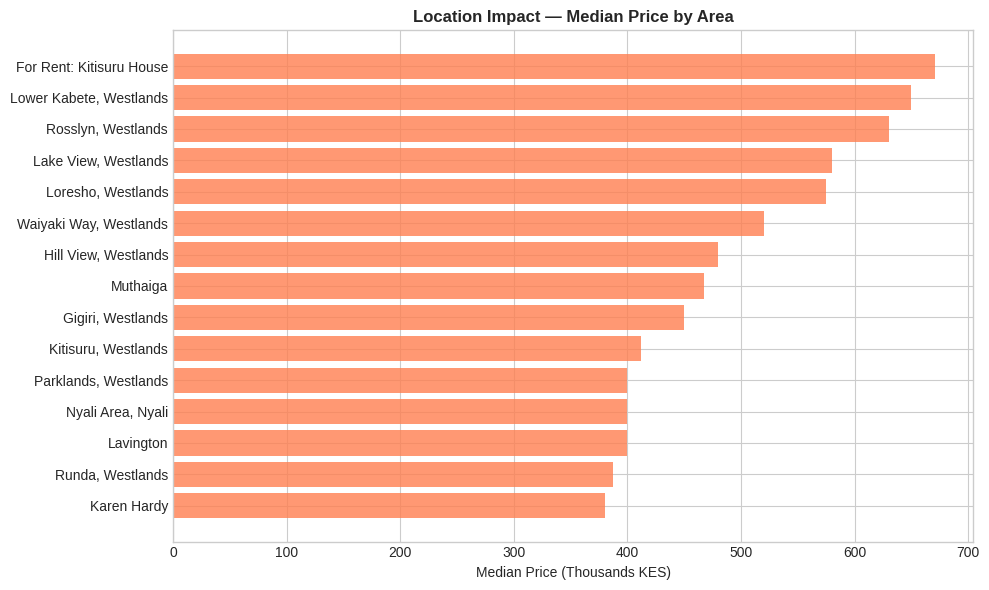


Top 10 locations by median price (KES):
location
For Rent: Kitisuru House   671,000.00
Lower Kabete, Westlands    650,000.00
Rosslyn, Westlands         630,000.00
Lake View, Westlands       580,000.00
Loresho, Westlands         575,000.00
Waiyaki Way, Westlands     520,000.00
Hill View, Westlands       480,000.00
Muthaiga                   467,500.00
Gigiri, Westlands          450,000.00
Kitisuru, Westlands        412,000.00
Saved: data/feature_importance_locations.png


In [11]:
# Location Impact
loc_imp = imp_df[imp_df['Feature'] == 'location_enc']
if len(loc_imp) > 0:
    print(f"\nLocation importance: {loc_imp['Importance'].values[0]:.4f}")

loc_prices = df_model.groupby('location')['price_kes'].median().sort_values(ascending=True).tail(15)
fig, ax = plt.subplots(figsize=(10, 6))
# Use thousands for rent (e.g. 40K–1.2M), millions for sale
if y.max() <= 5e6:
    loc_vals = loc_prices.values / 1e3
    ax.set_xlabel('Median Price (Thousands KES)')
else:
    loc_vals = loc_prices.values / 1e6
    ax.set_xlabel('Median Price (Million KES)')
ax.barh(loc_prices.index, loc_vals, color='coral', alpha=0.8)
ax.set_title('Location Impact — Median Price by Area', fontweight='bold')
plt.tight_layout()
plt.savefig('data/feature_importance_locations.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nTop 10 locations by median price (KES):")
print(df_model.groupby('location')['price_kes'].median().sort_values(ascending=False).head(10).to_string())
print("Saved: data/feature_importance_locations.png")